In [1]:
#The first stage in processing in Python is to import the modules (which are collections of functions) that we will be using
#in our analysis. Here, the most important module to note is SpecDAL, a module designed to handle and process field
#spectroscopy data.

import os    #a module that allows us to "talk" with our operating system, neccessary for handling paths, files and so on
from pathlib import Path #a more specific path handling module that allows us to quickly create path names
from specdal import Collection, Spectrum, read #We import our main package, specdal, and ask to only import certain key functions
import pandas as pd   #Pandas is a powerful module for the handling of data sets
from matplotlib import pyplot as plt   #matplotlib emulates the functions of MATLAB. Here, we tell matplotlib to only import one of it's functions, the pyplot function, and to import it with the identifier 'plt'
from matplotlib.pyplot import ylabel, xlabel, title, legend   #We go even further by asking pyplot to only import some of it's subfunctions
from scipy.signal import savgol_filter   #We will use this to smooth our data
import numpy as np #We require numpy for integration functions that will be used during convolution
import shutil #A clean up utility to remove files at the end of our session 

In [2]:
#Here, we set the path to the folder containing the field spectroscopy data collected . 
#Check the printed output here to make sure that this is the correct path to your .sig files
os.chdir('/Users/user/OneDrive - Nexus365/01 OXFORD PHD/Field Work 2023/SVC_2023/all_wytham')
cwd = Path.cwd()
print(cwd)
Data_Dir = cwd/"data" #The sub-directory where our .sig files are located
print(Data_Dir)
csv_Dir = cwd / "csv" #The sub-directory which will store generated .csv files which at the end of our workshop will be deleted 
print(csv_Dir)

/Users/user/Library/CloudStorage/OneDrive-Nexus365/01 OXFORD PHD/Field Work 2023/SVC_2023/all_wytham
/Users/user/Library/CloudStorage/OneDrive-Nexus365/01 OXFORD PHD/Field Work 2023/SVC_2023/all_wytham/data
/Users/user/Library/CloudStorage/OneDrive-Nexus365/01 OXFORD PHD/Field Work 2023/SVC_2023/all_wytham/csv


In [3]:
#We will now use the SpecDAL package to read our .sig files, and assign them to a collection of spectra which we can
#analyse and process further

All = Collection(name='all_wytham')
sort=sorted(os.listdir(Data_Dir))

for x in range(1,len(sort)):
  spectrum=Spectrum(filepath=os.path.join(Data_Dir,sort[x]))
  All.append(spectrum)



In [4]:
#Let's now take a look at this spectra collection. First of all, let's have a look at the header information for the
#first 10 spectra in our collection...

print(type(All.spectra))
for s in All.spectra[0:2]:
    print(s)

<class 'list'>

name:		010823_A1.0001,
measure_type:	pct_reflect
measurements:	wave  |measurement
		------|-----------
		 339.8|0.097
		   ...|...
		2517.5|0.037
metadata:	file:/Users/user/Library/CloudStorage/OneDrive-Nexus365/01 OXFORD PHD/Field Work 2023/SVC_2023/all_wytham/data/010823_A1.0001.sig
		instrument_type:SIG
		integration_time:50.666666666666664
		measurement_type:Radiance
		gps_time_ref:93845.0
		gps_time_tgt:94019.0
		wavelength_range:(339.8, 2517.5)


name:		010823_A1.0002,
measure_type:	pct_reflect
measurements:	wave  |measurement
		------|-----------
		 339.8|0.068
		   ...|...
		2517.5|0.035
metadata:	file:/Users/user/Library/CloudStorage/OneDrive-Nexus365/01 OXFORD PHD/Field Work 2023/SVC_2023/all_wytham/data/010823_A1.0002.sig
		instrument_type:SIG
		integration_time:50.666666666666664
		measurement_type:Radiance
		gps_time_ref:93845.0
		gps_time_tgt:94033.0
		wavelength_range:(339.8, 2517.5)



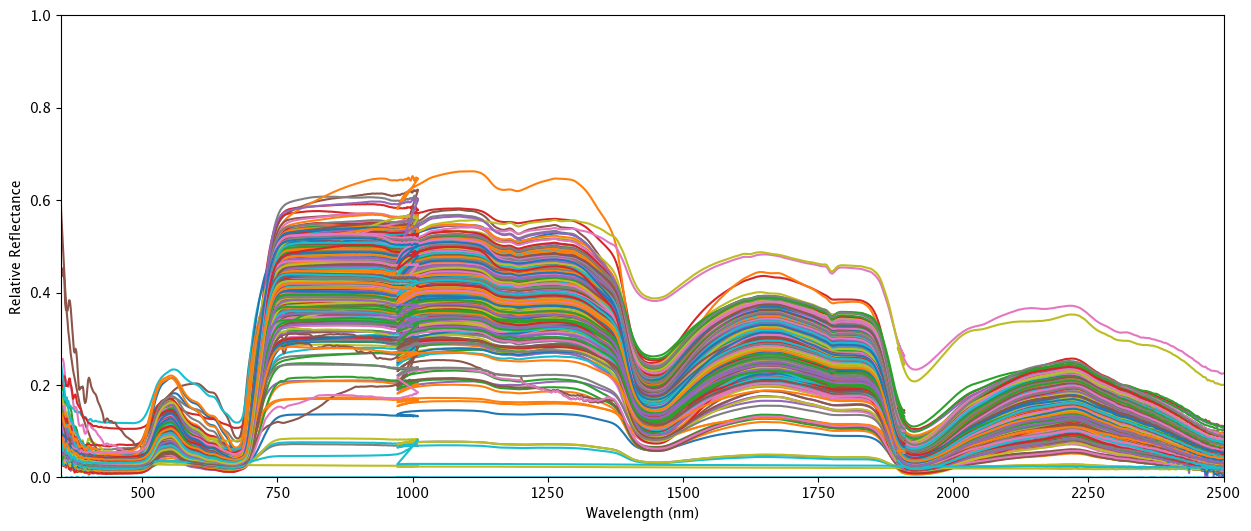

In [5]:
#We can take a visual look at the data...
All.plot(figsize=(15, 6), legend = None, ylim=(0,1), xlim=(350, 2500), ylabel=("Relative Reflectance"), xlabel=("Wavelength (nm)")) 
plt.show()

Splicing overlap regions complete!


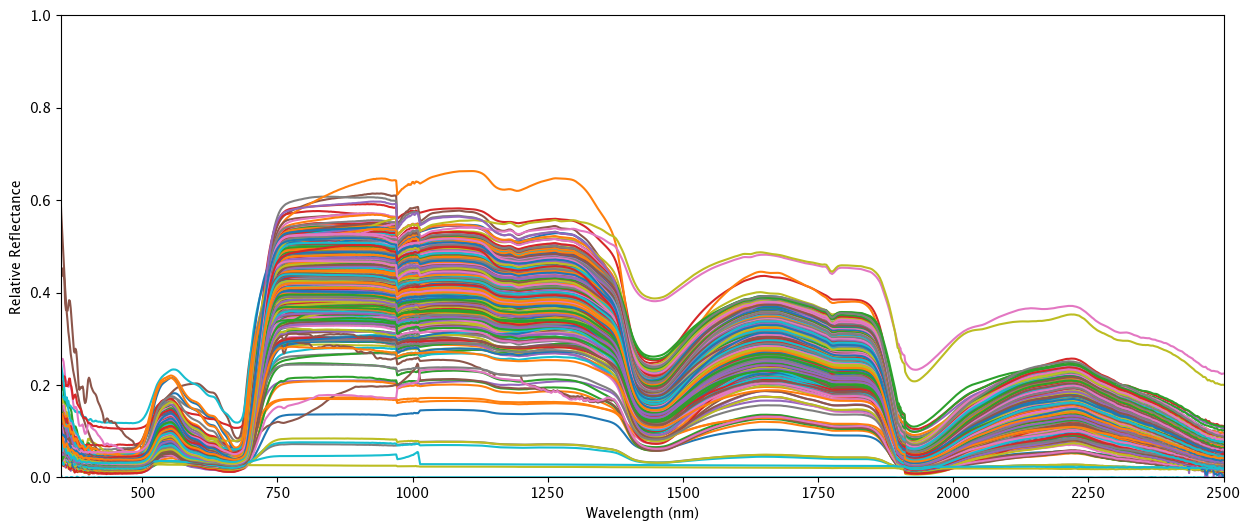

In [6]:


#fix the overlap regions in our spectra by using the inbuilt specdal functions. 

All.stitch(method='mean')
All.jump_correct(splices=[1000, 1800], reference=0)

print("Splicing overlap regions complete!")

All.plot(figsize=(15, 6), legend = None, ylim=(0,1), xlim=(350, 2500), ylabel=("Relative Reflectance"), xlabel=("Wavelength (nm)")) 
plt.show()

In [7]:
#Notice that the steps between the wavelengths correspond to the spectral resolution of the instrument.
#We want to interpolate reflectance measurements that correspond to wavelengths with 1.0 nm spacing.
#This can be done using specdal as follows -- 

  
All.interpolate(spacing=1, method='slinear')
print('spectra interpolated!')

spectra interpolated!


Absolute reflectances derived!


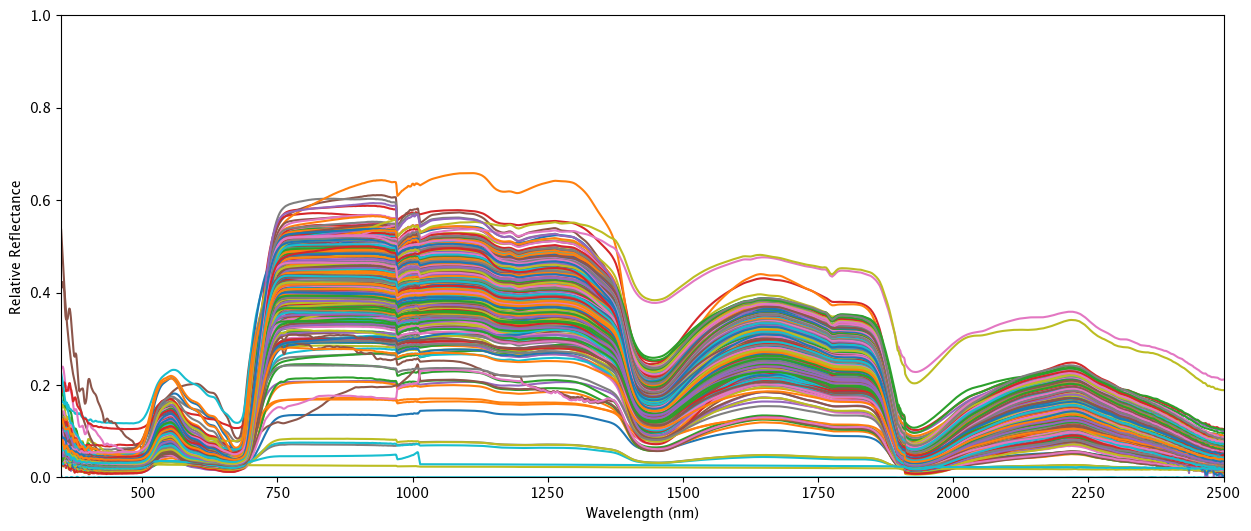

In [8]:
#Notice from our previous graphs that the y-axes are labelled "Relative Reflectance". This is because these spectra were
#recorded relative to the reflectance of the white Spectralon panel. We take measurements relative to this panel to approximate 
#the total irradiance coming from the sun and hitting the object you are interested in taking a spectral measurement of.
#Because the panel does not reflect 100% of the light that hits it in a completely uniform manner we need to adjust our 
#"Relative Reflectance" measurements using the panel's known, laboratory calibrated reflectance to convert our field 
#measurements to absolute reflectance.

#We can derive the absolute reflectance then by multiplying our field measurements by the spectral reflectance of the panel for
#each wavelength. In the home folder, you'll find one such file called SRT_44 (the serial code of the panel used on Dryden Farm).
#We can use this file to convert our measurements as follows. We are creating new dataframes that will host the corrected values, 
#but the original dataframe can be corrected without having to assign a new identifier! 
reference_panel = pd.read_csv('/Users/user/OneDrive - Nexus365/01 OXFORD PHD/Bangor/FSF LOAN 2022/SVC Software + Panel Cal + Field Guide/SRT_080322_wrt_Primary.csv', index_col = "Wavelength") 

All_AbsoluteRef= All.data.mul(reference_panel['Reflectance'], axis = 0)

print("Absolute reflectances derived!")

All_AbsoluteRef.plot(figsize=(15, 6), legend = None, ylim=(0,1), xlim=(350, 2500), ylabel=("Relative Reflectance"), xlabel=("Wavelength (nm)")) 
plt.show()


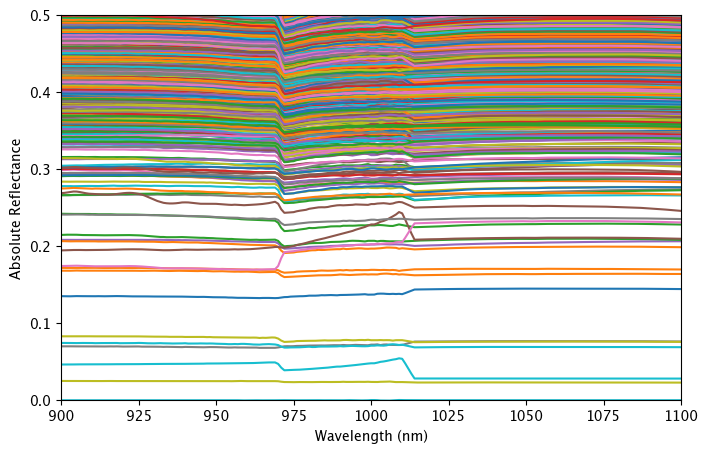

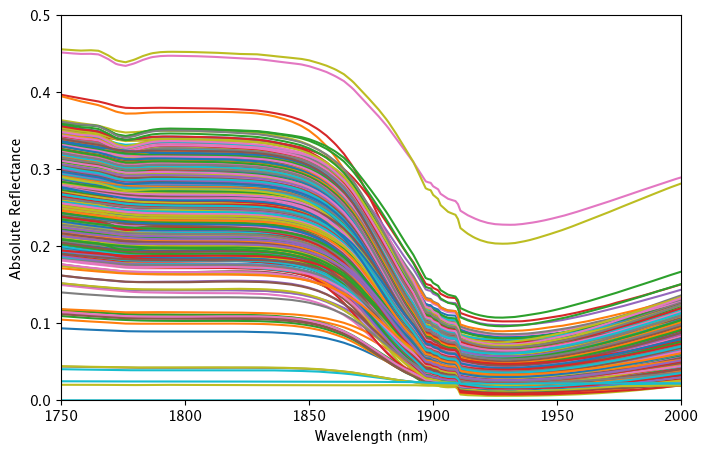

In [21]:
#You may have noticed a few noisy regions in the plots. Can you see them?
#Let's zoom in around two regions in the Vegetation collection -- 1350 to 1460 nm, and 1790 to 1970 nm
All_AbsoluteRef.plot(figsize=(8, 5), legend = False, ylim=(0,0.5), xlim=(900, 1100),xlabel=("Wavelength (nm)"),ylabel=("Absolute Reflectance"))
plt.show()

All_AbsoluteRef.plot(figsize=(8, 5), legend = False, ylim=(0,0.5), xlim=(1750, 2000),xlabel=("Wavelength (nm)"),ylabel=("Absolute Reflectance"))
plt.show()

In [22]:
#These noisy regions are caused by the absorption of solar irradiance by water vapour in the atmopshere and can interfere with 
#classification or use in indices. If the noise isn't too bad then smoothing may be suffcient to get rid of it, otherswise 
#we will need to remove the noisy regions. let's smooth our data set using a Savitsky-Golay filter.

All_AbsoluteRef.to_csv(str(csv_Dir) + "/" + r'All_AbsRef.csv')
All_AbsoluteRef_Smoothing = pd.read_csv(str(csv_Dir) + "/" + r'All_AbsRef.csv', index_col=0, header=0)
All_AbsoluteRef_Smoothing.drop(All_AbsoluteRef_Smoothing.index[0:10], inplace = True)
All_AbsoluteRef_Smoothing.drop(All_AbsoluteRef_Smoothing.index[2151:], inplace = True)
All_AbsoluteRef_Smoothing = All_AbsoluteRef_Smoothing.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()
All_AbsoluteRef_Smoothed = pd.DataFrame(savgol_filter(All_AbsoluteRef_Smoothing, 41, 2, axis=0),
                                columns=All_AbsoluteRef_Smoothing.columns,
                                index=All_AbsoluteRef_Smoothing.index)


print("Smoothing complete")

Smoothing complete


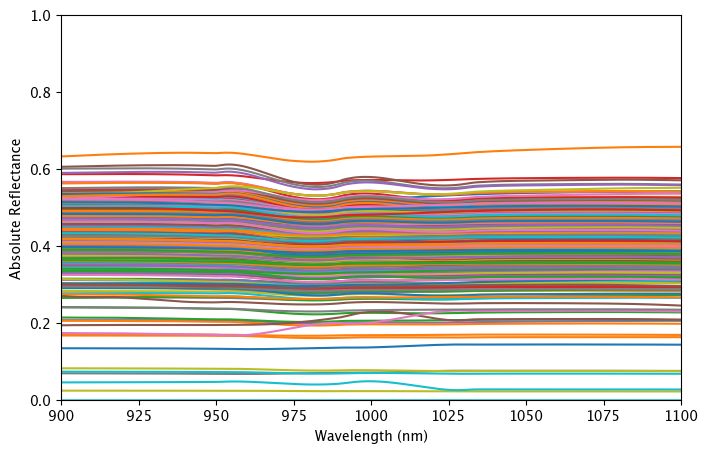

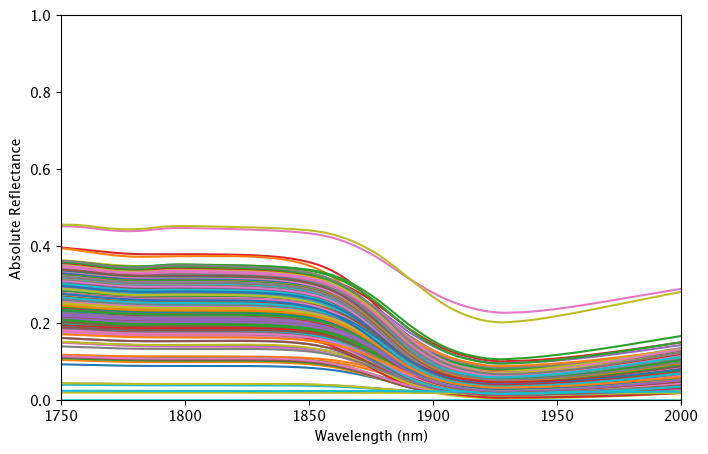

In [23]:
#Let's take a look at how that changed things --
All_AbsoluteRef_Smoothed.plot(figsize=(8, 5), legend = False, ylim=(0,1), xlim=(900, 1100),xlabel=("Wavelength (nm)"), ylabel=("Absolute Reflectance"))
plt.show()


All_AbsoluteRef_Smoothed.plot(figsize=(8, 5), legend = False, ylim=(0,1), xlim=(1750, 2000),xlabel=("Wavelength (nm)"), ylabel=("Absolute Reflectance"))
plt.show()



        010823_A1.0001  010823_A1.0002  010823_A1.0003  010823_A1.0004  \
350.0         0.058253        0.048452        0.058270        0.056031   
351.0         0.057105        0.047471        0.057124        0.055210   
352.0         0.055981        0.046513        0.056000        0.054399   
353.0         0.054882        0.045580        0.054900        0.053598   
354.0         0.053807        0.044671        0.053822        0.052809   
...                ...             ...             ...             ...   
2496.0        0.036612        0.034492        0.029731        0.034948   
2497.0        0.036478        0.034483        0.029626        0.034715   
2498.0        0.036349        0.034488        0.029526        0.034481   
2499.0        0.036223        0.034507        0.029430        0.034247   
2500.0        0.036102        0.034539        0.029339        0.034013   

        010823_A1.0005  010823_A2.0000  010823_A2.0001  010823_A2.0002  \
350.0         0.075341        0.05174

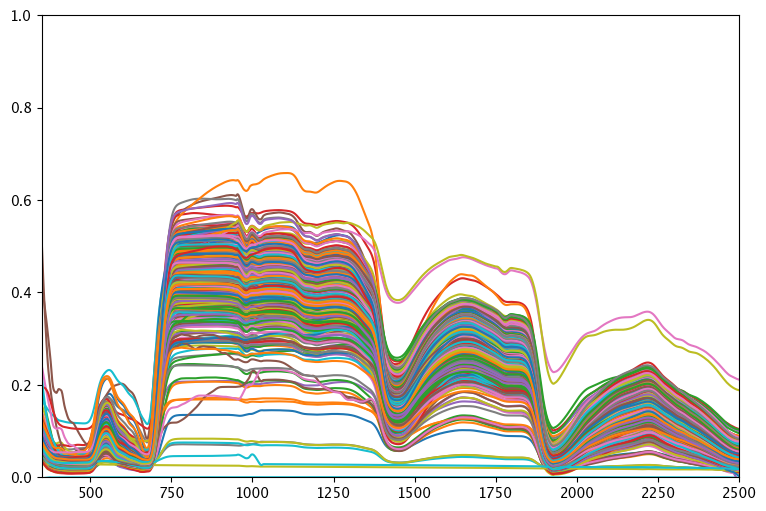

In [24]:

#save combined spectral library as CSV
All_AbsoluteRef_Smoothed.to_csv(r'Wytham_Hyperspectral.csv')

print(All_AbsoluteRef_Smoothed)

All_AbsoluteRef_Smoothed.plot(figsize=(9, 6), legend = False, ylim=(0,1), xlim=(350, 2500))
plt.show()